# K-Nearest Neighbors (Regression)

This notebook implements the constructed k-nearest neighbors (KNN) regression algorithm on a ***TODO: FINISH THIS***. For a more comprehensive overview of the ***way the algorithm works***, see the associated README ***link this here***.

**sections i want: library imports, data loading/explanation, visualization of data, knn with 2 features and visualization, knn with multiple features, accuracy across different values of k, then different metrics, comparison with scikit learn for metrics**

***acknowledge that many steps are similar for classification***

### Library Imports
This section imports the libraries **and modules** required to run the KNN algorithm. The **following dependencies are required**

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.knn import *
from rice_ml.postprocess.regressionpost import *

### Data Loading & Cleaning
The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms due to its **clear-cut features/simplicity/not too large/other benefits**. It has been chosen **because it is simple for classification** and requires several preprocessing steps, including **handling missing values**, which **showcase the preprocessing modules/package**. This dataset contains the following feature data for 344 penguins:
- Species: **fill this in, three species - 'Adelie' 'Chinstrap' 'Gentoo'**
- Island: **fill this in - 'Biscoe' 'Dream' 'Torgersen'**
- Bill Length (mm): continuous values, measuring bill length in millimeters
- Bill Depth (mm): continuous values, measuring bill depth in millimeters
- Flipper Length (mm): continuous values, measuring flipper length in millimeters
- Body Mass (g): continuous values, measuring body mass in grams
- Sex: **binary male/female**

**we drop some features - this is different from classification!** 
**This section covers the actual loading of the data; the data is loaded using `sns.load_dataset("penguins")`. Explanation here!! why those features?? encode using pandas uniques. Then cleaned using preprocessing - dropped missing values, identified outliers with z-scoring and dropped, dropped duplicates, z-scored the feature data for standardization**

In [119]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]
display(penguin_features)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


The dataset contains **some missing values (e.g., row 4)** and **may contain outliers or duplicates**. As in classification, to **put the data in a usable format**, we apply a series of preprocessing **algorithms**, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [120]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in KNN regression and **for ease of visualization**, the dataset must be split into the target feature and the remaining **features**. **We are interested in seeing if we can predict flipper length from bill length, bill depth, and body mass**

In [121]:
# Creating two arrays
flipper_length = penguin_features_cleaned[:, 2]
penguin_feature_data = penguin_features_cleaned[:, [0, 1, 3]]
print(f"Array for flipper length (first five entries): \n {flipper_length[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for flipper length (first five entries): 
 [181. 186. 195. 193. 190.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7 3750. ]
 [  39.5   17.4 3800. ]
 [  40.3   18.  3250. ]
 [  36.7   19.3 3450. ]
 [  39.3   20.6 3650. ]]


### Data Visualization

**fill this in!!**

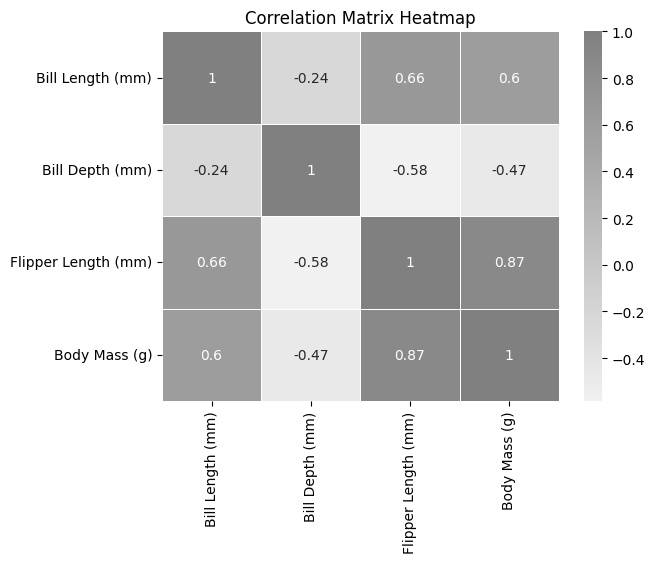

In [122]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap=sns.light_palette('gray', as_cmap=True), linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Body mass in grams and bill length in millimeters have the greatest correlation with flipper length, so **we will select these two for the initial regression.** The relationship between these three variables can be visualized on a two-dimensional plot, where **body mass/bill length are on the axes** and the **colormap is associated/indicates flipper length**

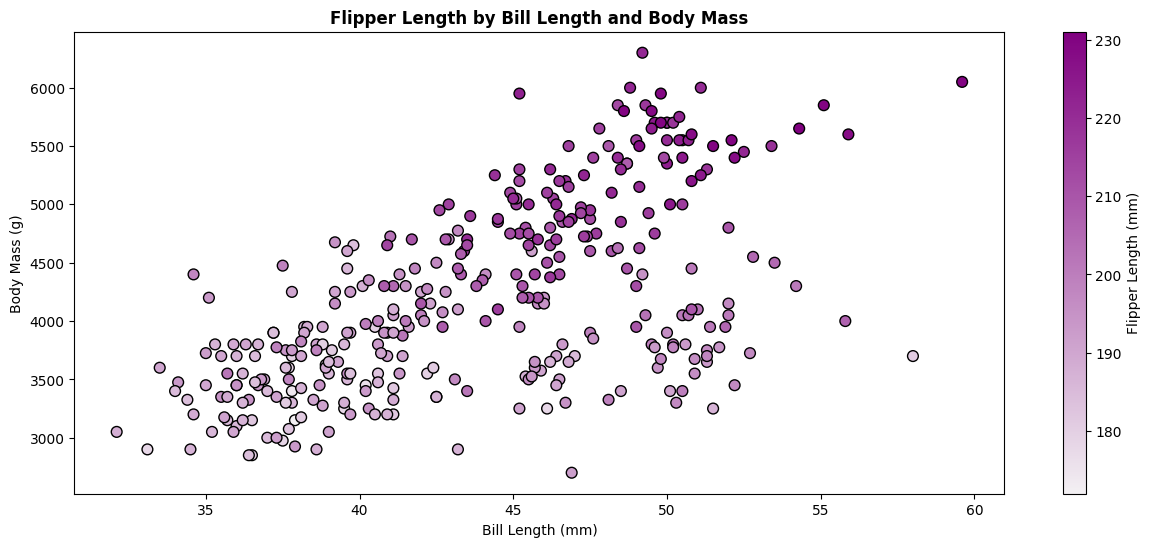

In [123]:
# Plotting bill length and bill depth, color-coded by flipper length
plt.figure(figsize = (15, 6))
plt.scatter(penguin_feature_data[:, 0], penguin_feature_data[:, 2], c = flipper_length, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
cbar = plt.colorbar()
cbar.set_label("Flipper Length (mm)")
plt.xlabel("Bill Length (mm)")
plt.ylabel("Body Mass (g)")
plt.title("Flipper Length by Bill Length and Body Mass", fontweight = 'bold')
plt.show()

There appears to be **a general positive trend in these variables**. As bill length and body mass increase, flipper length increases as well. **thus it is reasonable to use in regression**

### KNN Implementation (2 Features)

This section **implements a basic KNN regression algorithm for the two identified features to attempt to classify species**. **elaborate!!** 

**To avoid skewing results with different feature values**, we standardize the feature data **by calculating zscores** using the `z_score_standardize` **module** from the preprocessing package. This ensures that **no feature dominates/overrides the other ones** by **making them all the same scale**. The z-score equation used is **this!!**

In [ ]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 2]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874 -0.56414208]
 [-0.81112573 -0.50170305]
 [-0.66437972 -1.18853234]
 [-1.32473679 -0.93877623]
 [-0.84781224 -0.68902013]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. **stratification/0.3 test_array size**. There are 342 samples in **the cleaned dataset**, so the training array should have around 239/240 samples and the testing should have around 102/103.

In [125]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, flipper_length)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (239, 2)
Shape of training targets: (239,)
Shape of testing array: (103, 2)
Shape of testing targets: (103,)


**Next, we apply KNN regression by initializing a `knn_regression` class from the supervised learning package, and fitting it on the training data**. The test feature data is then **fed into** the fit model to predict flipper length **from previously unseen data**. **This model uses 3 neighbors and euclidean distance, although these parameters are variable (see section below)**.

In [126]:
# Fitting the model
knn = knn_regressor()
knn.fit(train_array, train_targets)

# Predicting flipper length based on testing data
prediction = knn.prediction(test_array)

**adjust this for regression - When the model has been successfully called/fit, we calculate a variety of postprocessing/accuracy/scoring metrics using the postprocessing package**. These include **accuracy, a visualization of the confusion matrix, and precision/recall/f1 scores for each one**. **fix this!! plot with the scores**. The **plot below shows the classification for the test cases plotted against the correct labels for the entire dataset; the rightmost plot contains the same plots/labels, but with the incorrectly classified points labeled in yellow.**

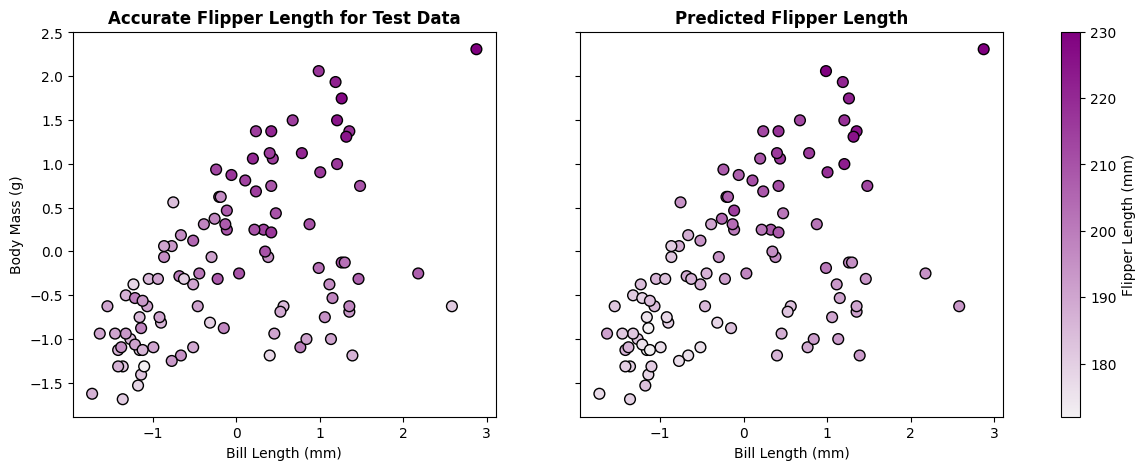

In [ ]:
# Plotting bill length and body mass for actual and predicted data, color-coded by flipper length
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)
plot_1 = ax[0].scatter(test_array[:, 0], test_array[:, 1], c = test_targets, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[0].set_xlabel("Bill Length (mm)")
ax[0].set_ylabel("Body Mass (g)")
ax[0].set_title("Accurate Flipper Length for Test Data", fontweight = 'bold')

plot_2 = ax[1].scatter(test_array[:, 0], test_array[:, 1], c = prediction, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[1].set_xlabel("Bill Length (mm)")
ax[1].set_title("Predicted Flipper Length", fontweight = 'bold')

cbar = fig.colorbar(plot_1, ax = ax, location = 'right')
cbar.set_label("Flipper Length (mm)")
plt.show()

In [128]:
# Evaluating the model
print_model_metrics(prediction, test_targets, n_features = 2)

Model Metrics 
------------- 
MAE: 5.41 
MSE: 46.95 
RMSE: 6.85 
R2: 0.74 
Adjusted R2: 0.73


**description of the model - TODO!**

### KNN Implementation (Changing Parameters)

This section **implements a basic KNN regression algorithm for the two identified features to attempt to classify species**, but **with different types of parameters. It first determines the R2 for various values of k using Euclidean distance, then for different distance metrics with the ideal k.**

**the first part looks at R2 for different values of k as an evaluation for which is the best k; the second looks at distance, the third at weighting**

In [129]:
# Arrays for k-values and R2
k_values = np.arange(1, 16)
r2_k = np.full(len(k_values), np.nan)

# Fitting and scoring the model for each value of k
for i in range(len(k_values)):
    knn = knn_regressor(k = k_values[i])
    knn.fit(train_array, train_targets)
    r2 = knn.scoring(test_array, test_targets)
    r2_k[i] = r2

r2_k

array([0.6548794 , 0.73773326, 0.7380312 , 0.75012478, 0.76810669,
       0.76593656, 0.77803118, 0.77133086, 0.77306216, 0.77560065,
       0.77527771, 0.78278924, 0.78393129, 0.7863986 , 0.78579831])

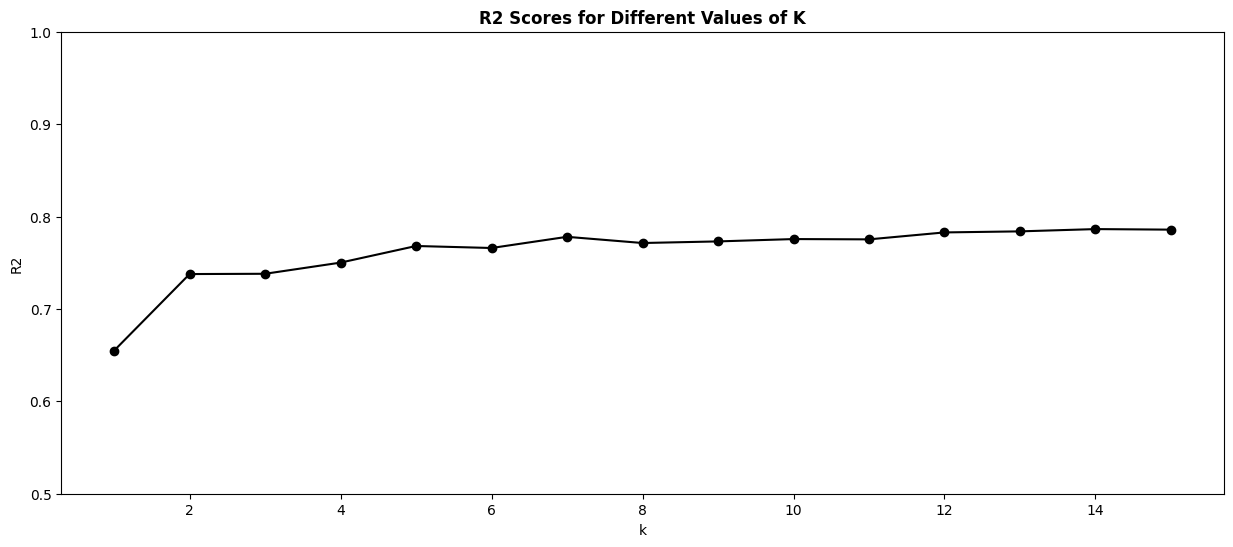

In [130]:
# Plotting the change in F2 across different k-values
plt.figure(figsize = (15, 6))
plt.plot(k_values, r2_k, 'black')
plt.scatter(k_values, r2_k, color = 'black')
plt.title("R2 Scores for Different Values of K", fontweight = 'bold')
plt.xlabel("k")
plt.ylabel("R2")
plt.ylim(0.5, 1)
plt.show()

**interpretation - it tends to plateau, so 3 is fine - TODO**

In [131]:
# Arrays for distance type and R2
dist_type = ['euclidean', 'manhattan', 'minkowski', 'minkowski', 'minkowski']
R2_dist = np.full(5, np.nan)

# Fitting and scoring the model for different distance metrics
for i in range(len(dist_type)):
    knn = knn_regressor(k = 3, metric = dist_type[i], p = i + 1)
    knn.fit(train_array, train_targets)
    R2 = knn.scoring(test_array, test_targets)
    R2_dist[i] = R2

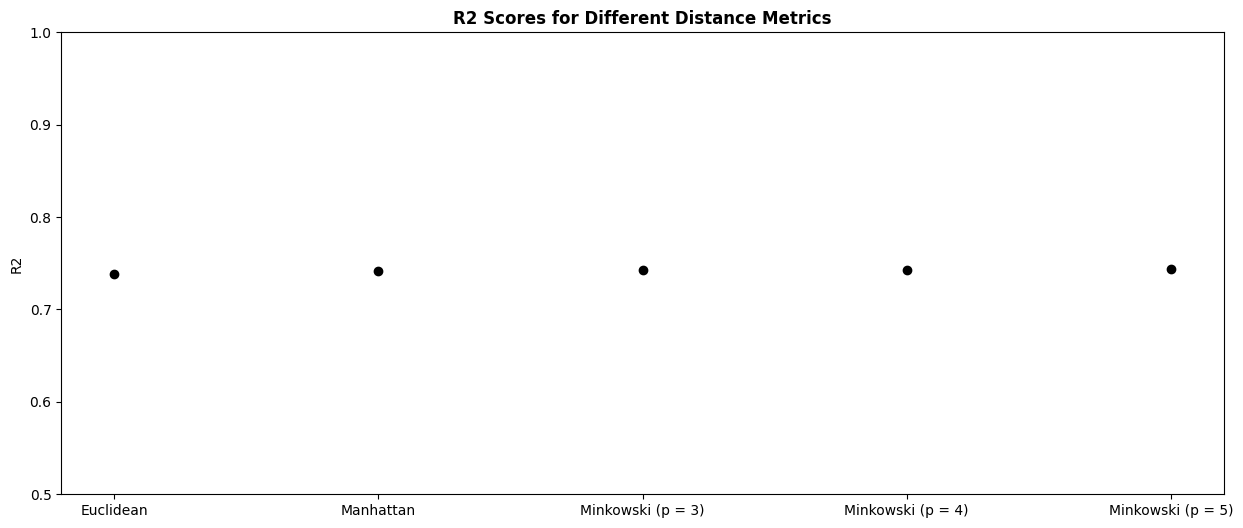

In [132]:
# Plotting the change in R2 across different k-values
plt.figure(figsize = (15, 6))
plt.scatter(["Euclidean", "Manhattan", "Minkowski (p = 3)", "Minkowski (p = 4)", "Minkowski (p = 5)"], R2_dist, color = 'black')
plt.title("R2 Scores for Different Distance Metrics", fontweight = 'bold')
plt.ylabel("R2")
plt.ylim(0.5, 1.0)
plt.show()

**fairly constant across distance metrics - TODO!!**

### KNN Implementation (Multiple Features)

**this section implements KNN regression in the same way using multiple features to see if it improves model accuracy/works**. As before, we begin by standardizing all features and splitting the data into training and test sets, then **initializing/fitting a model**

In [133]:
# Standardizing the features and target variable
penguin_feature_data_normal_mult = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_mult[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -0.56414208]
 [-0.81112573  0.1261879  -0.50170305]
 [-0.66437972  0.43046236 -1.18853234]
 [-1.32473679  1.08972369 -0.93877623]
 [-0.84781224  1.74898502 -0.68902013]]


In [134]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_mult, flipper_length)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (239, 3)
Shape of training targets: (239,)
Shape of testing array: (103, 3)
Shape of testing targets: (103,)


In [135]:
# Fitting the model
knn_mult = knn_regressor()
knn_mult.fit(train_array_mult, train_targets_mult)

# Predicting flipper length based on testing data
prediction_mult = knn_mult.prediction(test_array_mult)

In [136]:
# Evaluating the model
print_model_metrics(prediction_mult, test_targets_mult, n_features = 2)

Model Metrics 
------------- 
MAE: 3.87 
MSE: 27.77 
RMSE: 5.27 
R2: 0.85 
Adjusted R2: 0.84


This model predicts flipper length **with slightly higher R2/better than the model that only contains two features, and adjusted R2 is not low, indicating that it is not overfit**. **more elaboration!!**

### Comparison with Existing Models

**This section compares this KNN regressor, which was built in the supervised learning package**, with the **established models using SciKit Learn**. It **evaluates the model accuracy on the entire dataset using the same k and same distance metrics to determine which is a better fit/if both are good, since SciKit Learn is the gold standard/well-established**

In [137]:
from sklearn.neighbors import KNeighborsRegressor
knn_sk = KNeighborsRegressor(n_neighbors = 3, metric = 'euclidean')
knn_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = knn_sk.predict(test_array_mult)

In [138]:
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
MAE: 3.87 
MSE: 27.77 
RMSE: 5.27 
R2: 0.85 
Adjusted R2: 0.85


The **established sklearn KNN classifier has metrics similar to that of the constructed class/model**. Thus, this **test verifies this version of KNN as sufficient for regression. elaborate!!**